In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v2 import Autoencoder
from tools.ConvESN_v3_AR import ESN as AR_RNN_ESN
from tools.AEConvESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-02-20 20:00:25.590864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-20 20:00:25.591343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:25.624398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:25.624686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:25.624921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:25.625146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ConvESN/ESN_008'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('data_dir_idx:', data_dir_idx)
print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004
data_dir_idx: 000
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_008
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
24 <class 'int'>


In [12]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [13]:
lyap_time = 1/0.065
delta_t = 1.
T = t_recorded_samples[-1]

In [14]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [15]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [16]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/lyap_time
    num_timesteps_warmup = 1*lyap_time/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*lyap_time
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        # 'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [2e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [50],
        [50],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-3  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 16
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [22]:
%pdb

Automatic pdb calling has been turned ON




********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


2023-02-20 20:00:31.866705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


(497, 62, 5000) (497, 5, 5000)
init Wres made : 6.345311403274536 s.
Wres pp dealt with : 9.734102249145508 s.
sparse Wres made : 19.31165838241577 s.
spectral radius found : 65.21833682060242 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 0.0413 - mse: 0.0048 - NMSE: 0.0438 - covmat_fro_loss: 0.0138 - global_gradnorm: 16.3796 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 25.4s

Epoch 1: val_NMSE improved from inf to 0.07190, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesChe

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0344 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 0.0130 - global_gradnorm: 11.7709 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0334 - val_mse: 0.0039 - val_NMSE: 0.0354 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
25/25 [==============================] - ETA: 0s - loss: 0.0355 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 0.0132 - global_gradnorm: 14.6017 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 4.6s

Epoch 10: val_NMSE improved from 0.03541 to 0.03519, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss

Epoch 19/1000
25/25 [==============================] - ETA: 0s - loss: 0.0327 - mse: 0.0038 - NMSE: 0.0347 - covmat_fro_loss: 0.0129 - global_gradnorm: 10.8397 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 3m 44.0s

Epoch 19: val_NMSE improved from 0.03327 to 0.03294, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 458ms/step - loss: 0.0327 - mse: 0.0038 - NMSE: 0.0347 - covmat_fro_loss: 0.0129 - global_gradnorm: 10.7071 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0310 - val_mse: 0.0037 - val_NMSE: 0.0329 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 447ms/step - loss: 0.0310 - mse: 0.0036 - NMSE: 0.0328 - covmat_fro_loss: 0.0125 - global_gradnorm: 8.6292 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0300 - val_mse: 0.0035 - val_NMSE: 0.0319 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 29/1000
25/25 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0126 - global_gradnorm: 8.3902 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 5m 34.6s

Epoch 29: val_NMSE did not improve from 0.03186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outs

Epoch 38/1000
25/25 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0035 - NMSE: 0.0316 - covmat_fro_loss: 0.0125 - global_gradnorm: 7.9943 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 7m 13.6s

Epoch 38: val_NMSE did not improve from 0.03186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0298 - mse: 0.0035 - NMSE: 0.0316 - covmat_fro_loss: 0.0125 - global_gradnorm: 8.0575 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0301 - val_mse: 0.0035 - val_NMSE: 0.0320 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 39/1000
25/25 [==============================] - ETA: 0s - loss: 0.0304 - mse: 0.0036 - NMSE: 0.0321 - covmat_fro_loss: 0.0125 - global_gradnor

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 449ms/step - loss: 0.0307 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0126 - global_gradnorm: 8.1551 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0292 - val_mse: 0.0034 - val_NMSE: 0.0310 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 48/1000
25/25 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0034 - NMSE: 0.0308 - covmat_fro_loss: 0.0123 - global_gradnorm: 8.8166 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 9m 4.0s

Epoch 48: val_NMSE did not improve from 0.03098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outst

Epoch 57/1000
25/25 [==============================] - ETA: 0s - loss: 0.0284 - mse: 0.0033 - NMSE: 0.0301 - covmat_fro_loss: 0.0122 - global_gradnorm: 7.4270 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 10m 43.5s

Epoch 57: val_NMSE did not improve from 0.03008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0284 - mse: 0.0033 - NMSE: 0.0301 - covmat_fro_loss: 0.0121 - global_gradnorm: 7.5134 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0293 - val_mse: 0.0034 - val_NMSE: 0.0311 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 58/1000
25/25 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 0.0123 - global_gradno

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0272 - mse: 0.0032 - NMSE: 0.0288 - covmat_fro_loss: 0.0121 - global_gradnorm: 7.7180 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0299 - val_mse: 0.0035 - val_NMSE: 0.0317 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 67/1000
25/25 [==============================] - ETA: 0s - loss: 0.0277 - mse: 0.0032 - NMSE: 0.0293 - covmat_fro_loss: 0.0122 - global_gradnorm: 7.1513 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 33.8s

Epoch 67: val_NMSE did not improve from 0.02967
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_out

Epoch 76/1000
25/25 [==============================] - ETA: 0s - loss: 0.0275 - mse: 0.0032 - NMSE: 0.0290 - covmat_fro_loss: 0.0121 - global_gradnorm: 9.4008 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 12.9s

Epoch 76: val_NMSE did not improve from 0.02912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0275 - mse: 0.0032 - NMSE: 0.0290 - covmat_fro_loss: 0.0122 - global_gradnorm: 9.3666 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0281 - val_mse: 0.0033 - val_NMSE: 0.0298 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 77/1000
25/25 [==============================] - ETA: 0s - loss: 0.0277 - mse: 0.0032 - NMSE: 0.0293 - covmat_fro_loss: 0.0122 - global_gradno

Epoch 86/1000
25/25 [==============================] - ETA: 0s - loss: 0.0281 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0122 - global_gradnorm: 13.0179 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 16m 3.0s

Epoch 86: val_NMSE did not improve from 0.02912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0281 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0122 - global_gradnorm: 13.1231 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0282 - val_mse: 0.0033 - val_NMSE: 0.0299 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 87/1000
25/25 [==============================] - ETA: 0s - loss: 0.0268 - mse: 0.0031 - NMSE: 0.0283 - covmat_fro_loss: 0.0120 - global_gradn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0277 - mse: 0.0032 - NMSE: 0.0293 - covmat_fro_loss: 0.0122 - global_gradnorm: 7.6823 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0273 - val_mse: 0.0032 - val_NMSE: 0.0290 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 96/1000
25/25 [==============================] - ETA: 0s - loss: 0.0261 - mse: 0.0030 - NMSE: 0.0276 - covmat_fro_loss: 0.0119 - global_gradnorm: 6.6888 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 17m 53.2s

Epoch 96: val_NMSE did not improve from 0.02833
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_out

Epoch 105/1000
25/25 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.2081 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 19m 32.4s

Epoch 105: val_NMSE did not improve from 0.02801
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0264 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0119 - global_gradnorm: 9.2710 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0265 - val_mse: 0.0031 - val_NMSE: 0.0281 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 106/1000
25/25 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0031 - NMSE: 0.0278 - covmat_fro_loss: 0.0119 - global_gra

Epoch 115/1000
25/25 [==============================] - ETA: 0s - loss: 0.0261 - mse: 0.0031 - NMSE: 0.0276 - covmat_fro_loss: 0.0119 - global_gradnorm: 7.5646 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 21m 22.6s

Epoch 115: val_NMSE did not improve from 0.02772
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0261 - mse: 0.0031 - NMSE: 0.0276 - covmat_fro_loss: 0.0119 - global_gradnorm: 7.5146 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0275 - val_mse: 0.0032 - val_NMSE: 0.0291 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 116/1000
25/25 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0117 - global_gra

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0253 - mse: 0.0030 - NMSE: 0.0267 - covmat_fro_loss: 0.0117 - global_gradnorm: 7.7069 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0263 - val_mse: 0.0031 - val_NMSE: 0.0278 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 125/1000
25/25 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0030 - NMSE: 0.0272 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.2490 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 23m 12.8s

Epoch 125: val_NMSE did not improve from 0.02738
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 134/1000
25/25 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0030 - NMSE: 0.0269 - covmat_fro_loss: 0.0118 - global_gradnorm: 7.7254 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 24m 52.0s

Epoch 134: val_NMSE did not improve from 0.02702
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0254 - mse: 0.0030 - NMSE: 0.0269 - covmat_fro_loss: 0.0119 - global_gradnorm: 7.7284 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0263 - val_mse: 0.0031 - val_NMSE: 0.0278 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 135/1000
25/25 [==============================] - ETA: 0s - loss: 0.0251 - mse: 0.0029 - NMSE: 0.0265 - covmat_fro_loss: 0.0117 - global_gra

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 446ms/step - loss: 0.0252 - mse: 0.0029 - NMSE: 0.0267 - covmat_fro_loss: 0.0118 - global_gradnorm: 7.9093 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0250 - val_mse: 0.0029 - val_NMSE: 0.0265 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 144/1000
25/25 [==============================] - ETA: 0s - loss: 0.0251 - mse: 0.0029 - NMSE: 0.0265 - covmat_fro_loss: 0.0117 - global_gradnorm: 6.6016 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 26m 42.4s

Epoch 144: val_NMSE did not improve from 0.02652
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 153/1000
25/25 [==============================] - ETA: 0s - loss: 0.0256 - mse: 0.0030 - NMSE: 0.0270 - covmat_fro_loss: 0.0119 - global_gradnorm: 8.7619 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 28m 21.4s

Epoch 153: val_NMSE did not improve from 0.02652
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0256 - mse: 0.0030 - NMSE: 0.0270 - covmat_fro_loss: 0.0119 - global_gradnorm: 8.9321 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0255 - val_mse: 0.0030 - val_NMSE: 0.0270 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 154/1000
25/25 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0029 - NMSE: 0.0265 - covmat_fro_loss: 0.0118 - global_gra

Epoch 163/1000
25/25 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0118 - global_gradnorm: 9.5033 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 30m 11.5s

Epoch 163: val_NMSE did not improve from 0.02652
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0257 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0117 - global_gradnorm: 9.5340 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0279 - val_mse: 0.0033 - val_NMSE: 0.0296 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 164/1000
25/25 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0028 - NMSE: 0.0255 - covmat_fro_loss: 0.0115 - global_gra

Epoch 173/1000
25/25 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0114 - global_gradnorm: 6.5429 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 1.7s

Epoch 173: val_NMSE did not improve from 0.02602
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 443ms/step - loss: 0.0233 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0114 - global_gradnorm: 6.6792 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0246 - val_mse: 0.0029 - val_NMSE: 0.0261 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 174/1000
25/25 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0113 - global_grad

Epoch 183/1000
25/25 [==============================] - ETA: 0s - loss: 0.0236 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0114 - global_gradnorm: 7.8551 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 33m 51.9s

Epoch 183: val_NMSE improved from 0.02568 to 0.02566, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 446ms/step - loss: 0.0236 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0114 - global_gradnorm: 7.8197 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0242 - val_mse: 0.0028 - val_NMSE: 0.0257 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 184/10

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0228 - mse: 0.0027 - NMSE: 0.0240 - covmat_fro_loss: 0.0113 - global_gradnorm: 6.5903 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0243 - val_mse: 0.0029 - val_NMSE: 0.0258 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 193/1000
25/25 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0028 - NMSE: 0.0255 - covmat_fro_loss: 0.0116 - global_gradnorm: 8.3988 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 35m 42.1s

Epoch 193: val_NMSE did not improve from 0.02550
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 202/1000
25/25 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0027 - NMSE: 0.0247 - covmat_fro_loss: 0.0114 - global_gradnorm: 7.7764 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 37m 21.2s

Epoch 202: val_NMSE did not improve from 0.02550
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0233 - mse: 0.0027 - NMSE: 0.0247 - covmat_fro_loss: 0.0114 - global_gradnorm: 7.6681 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0244 - val_mse: 0.0029 - val_NMSE: 0.0259 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 203/1000
25/25 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0240 - covmat_fro_loss: 0.0113 - global_gra

Epoch 212/1000
25/25 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0114 - global_gradnorm: 6.2232 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 39m 11.2s

Epoch 212: val_NMSE did not improve from 0.02550
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0231 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0114 - global_gradnorm: 6.2362 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0280 - val_mse: 0.0033 - val_NMSE: 0.0297 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 213/1000
25/25 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0113 - global_gra

Epoch 222/1000
25/25 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0112 - global_gradnorm: 6.9394 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 41m 1.3s

Epoch 222: val_NMSE did not improve from 0.02499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0112 - global_gradnorm: 6.9273 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0242 - val_mse: 0.0028 - val_NMSE: 0.0256 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 223/1000
25/25 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0240 - covmat_fro_loss: 0.0114 - global_grad

Epoch 232/1000
25/25 [==============================] - ETA: 0s - loss: 0.0237 - mse: 0.0028 - NMSE: 0.0250 - covmat_fro_loss: 0.0115 - global_gradnorm: 6.7205 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 42m 51.5s

Epoch 232: val_NMSE did not improve from 0.02481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0237 - mse: 0.0028 - NMSE: 0.0250 - covmat_fro_loss: 0.0118 - global_gradnorm: 6.8847 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0267 - val_mse: 0.0031 - val_NMSE: 0.0283 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 233/1000
25/25 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0113 - global_gra

Epoch 242/1000
25/25 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0113 - global_gradnorm: 7.8430 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 44m 41.6s

Epoch 242: val_NMSE did not improve from 0.02481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0224 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0112 - global_gradnorm: 7.8760 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0250 - val_mse: 0.0029 - val_NMSE: 0.0265 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 243/1000
25/25 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0025 - NMSE: 0.0230 - covmat_fro_loss: 0.0111 - global_gra

Epoch 252/1000
25/25 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 0.0113 - global_gradnorm: 10.0452 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 46m 31.7s

Epoch 252: val_NMSE did not improve from 0.02481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0229 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 0.0113 - global_gradnorm: 9.9932 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0252 - val_mse: 0.0030 - val_NMSE: 0.0267 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 253/1000
25/25 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0111 - global_gr

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0112 - global_gradnorm: 6.8748 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0249 - val_mse: 0.0029 - val_NMSE: 0.0264 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 262/1000
25/25 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0110 - global_gradnorm: 5.8338 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 48m 22.1s

Epoch 262: val_NMSE did not improve from 0.02439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 271/1000
25/25 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.8280 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 50m 1.2s

Epoch 271: val_NMSE did not improve from 0.02420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.8109 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0248 - val_mse: 0.0029 - val_NMSE: 0.0262 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 272/1000
25/25 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0110 - global_grad

Epoch 281/1000
25/25 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0024 - NMSE: 0.0219 - covmat_fro_loss: 0.0109 - global_gradnorm: 5.9237 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 51m 51.3s

Epoch 281: val_NMSE did not improve from 0.02420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0208 - mse: 0.0024 - NMSE: 0.0219 - covmat_fro_loss: 0.0108 - global_gradnorm: 6.0059 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0232 - val_mse: 0.0027 - val_NMSE: 0.0246 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 282/1000
25/25 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0111 - global_gra

Epoch 291/1000
25/25 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0111 - global_gradnorm: 7.9678 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 53m 41.3s

Epoch 291: val_NMSE did not improve from 0.02420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0111 - global_gradnorm: 7.8313 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0244 - val_mse: 0.0029 - val_NMSE: 0.0259 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 292/1000
25/25 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0025 - NMSE: 0.0230 - covmat_fro_loss: 0.0111 - global_gra

25/25 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0112 - global_gradnorm: 7.6112 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 55m 20.7s

Epoch 300: val_NMSE did not improve from 0.02379
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0112 - global_gradnorm: 7.5511 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0230 - val_mse: 0.0027 - val_NMSE: 0.0243 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 301/1000
25/25 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0111 - global_gradnorm: 10.3615 

Epoch 310/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0024 - NMSE: 0.0221 - covmat_fro_loss: 0.0110 - global_gradnorm: 7.0875 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 57m 10.9s

Epoch 310: val_NMSE did not improve from 0.02366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0210 - mse: 0.0024 - NMSE: 0.0221 - covmat_fro_loss: 0.0109 - global_gradnorm: 7.2514 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0256 - val_mse: 0.0030 - val_NMSE: 0.0271 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 311/1000
25/25 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0111 - global_gra

Epoch 320/1000
25/25 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0109 - global_gradnorm: 8.9104 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 59m 1.0s

Epoch 320: val_NMSE did not improve from 0.02359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0109 - global_gradnorm: 8.9440 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0244 - val_mse: 0.0029 - val_NMSE: 0.0258 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 321/1000
25/25 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0111 - global_grad

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0110 - global_gradnorm: 6.4284 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0230 - val_mse: 0.0027 - val_NMSE: 0.0244 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 330/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0221 - covmat_fro_loss: 0.0109 - global_gradnorm: 6.4255 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 0m 51.3s

Epoch 330: val_NMSE did not improve from 0.02324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_ou

Epoch 339/1000
25/25 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0024 - NMSE: 0.0219 - covmat_fro_loss: 0.0109 - global_gradnorm: 6.2926 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 2m 30.5s

Epoch 339: val_NMSE did not improve from 0.02316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0208 - mse: 0.0024 - NMSE: 0.0219 - covmat_fro_loss: 0.0108 - global_gradnorm: 6.1957 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0228 - val_mse: 0.0027 - val_NMSE: 0.0241 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 340/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0109 - global_grad

Epoch 349/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0109 - global_gradnorm: 10.5693 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 4m 20.4s

Epoch 349: val_NMSE did not improve from 0.02316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0109 - global_gradnorm: 10.4491 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0241 - val_mse: 0.0028 - val_NMSE: 0.0256 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 350/1000
25/25 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0025 - NMSE: 0.0225 - covmat_fro_loss: 0.0110 - global_gr

Epoch 359/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0109 - global_gradnorm: 8.2408 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 6m 10.5s

Epoch 359: val_NMSE did not improve from 0.02309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0109 - global_gradnorm: 8.2421 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0222 - val_mse: 0.0026 - val_NMSE: 0.0235 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 360/1000
25/25 [==============================] - ETA: 0s - loss: 0.0203 - mse: 0.0024 - NMSE: 0.0214 - covmat_fro_loss: 0.0108 - global_grad

Epoch 369/1000
25/25 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0110 - global_gradnorm: 8.3739 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 8m 0.7s

Epoch 369: val_NMSE did not improve from 0.02292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0110 - global_gradnorm: 8.1477 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0227 - val_mse: 0.0027 - val_NMSE: 0.0241 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 370/1000
25/25 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0025 - NMSE: 0.0223 - covmat_fro_loss: 0.0109 - global_gradn

Epoch 379/1000
25/25 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0109 - global_gradnorm: 8.1833 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 9m 50.7s

Epoch 379: val_NMSE did not improve from 0.02292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0206 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0108 - global_gradnorm: 8.1057 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0232 - val_mse: 0.0027 - val_NMSE: 0.0245 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 380/1000
25/25 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0024 - NMSE: 0.0213 - covmat_fro_loss: 0.0107 - global_grad

Epoch 389/1000
25/25 [==============================] - ETA: 0s - loss: 0.0201 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0107 - global_gradnorm: 4.9030 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 11m 40.6s

Epoch 389: val_NMSE did not improve from 0.02292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0201 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0108 - global_gradnorm: 4.8751 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0219 - val_mse: 0.0026 - val_NMSE: 0.0232 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 390/1000
25/25 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0108 - global_gra

Epoch 399/1000
25/25 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0107 - global_gradnorm: 6.3928 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 13m 30.8s

Epoch 399: val_NMSE did not improve from 0.02272
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0107 - global_gradnorm: 6.4321 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0225 - val_mse: 0.0026 - val_NMSE: 0.0238 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 400/1000
25/25 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0107 - global_gra

Epoch 409/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0108 - global_gradnorm: 7.2944 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 15m 21.0s

Epoch 409: val_NMSE did not improve from 0.02254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 7.3210 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0213 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 410/1000
25/25 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0107 - global_gra

Epoch 419/1000
25/25 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0106 - global_gradnorm: 6.4043 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 17m 11.0s

Epoch 419: val_NMSE did not improve from 0.02254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0106 - global_gradnorm: 6.3956 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0235 - val_mse: 0.0028 - val_NMSE: 0.0249 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 420/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0221 - covmat_fro_loss: 0.0109 - global_gra

Epoch 429/1000
25/25 [==============================] - ETA: 0s - loss: 0.0204 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0109 - global_gradnorm: 7.1844 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 19m 1.1s

Epoch 429: val_NMSE did not improve from 0.02231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 443ms/step - loss: 0.0204 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0109 - global_gradnorm: 7.0664 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0213 - val_mse: 0.0025 - val_NMSE: 0.0225 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 430/1000
25/25 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0106 - global_grad

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 447ms/step - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0209 - covmat_fro_loss: 0.0107 - global_gradnorm: 5.3737 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0209 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 439/1000
25/25 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0106 - global_gradnorm: 5.9392 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 20m 51.5s

Epoch 439: val_NMSE did not improve from 0.02214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 448/1000
25/25 [==============================] - ETA: 0s - loss: 0.0195 - mse: 0.0023 - NMSE: 0.0205 - covmat_fro_loss: 0.0106 - global_gradnorm: 8.6231 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 22m 30.5s

Epoch 448: val_NMSE did not improve from 0.02214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0195 - mse: 0.0023 - NMSE: 0.0205 - covmat_fro_loss: 0.0107 - global_gradnorm: 8.6273 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0214 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 449/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0024 - NMSE: 0.0221 - covmat_fro_loss: 0.0110 - global_gra

Epoch 458/1000
25/25 [==============================] - ETA: 0s - loss: 0.0201 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0106 - global_gradnorm: 9.3374 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 24m 20.5s

Epoch 458: val_NMSE did not improve from 0.02214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 443ms/step - loss: 0.0201 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0106 - global_gradnorm: 9.5669 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0216 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 459/1000
25/25 [==============================] - ETA: 0s - loss: 0.0204 - mse: 0.0024 - NMSE: 0.0215 - covmat_fro_loss: 0.0108 - global_gra

Epoch 468/1000
25/25 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 6.0331 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 26m 10.8s

Epoch 468: val_NMSE improved from 0.02214 to 0.02209, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 449ms/step - loss: 0.0208 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0110 - global_gradnorm: 6.1961 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0209 - val_mse: 0.0024 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 469/10

Epoch 478/1000
25/25 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0022 - NMSE: 0.0201 - covmat_fro_loss: 0.0105 - global_gradnorm: 5.7682 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 28m 1.0s

Epoch 478: val_NMSE improved from 0.02209 to 0.02153, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 448ms/step - loss: 0.0190 - mse: 0.0022 - NMSE: 0.0201 - covmat_fro_loss: 0.0105 - global_gradnorm: 5.7978 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0203 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 479/100

Epoch 488/1000
25/25 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0105 - global_gradnorm: 8.8117 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 29m 51.2s

Epoch 488: val_NMSE did not improve from 0.02153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0193 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0105 - global_gradnorm: 8.6678 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0211 - val_mse: 0.0025 - val_NMSE: 0.0223 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 489/1000
25/25 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0106 - global_gra

Epoch 498/1000
25/25 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0106 - global_gradnorm: 6.1790 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 31m 41.2s

Epoch 498: val_NMSE did not improve from 0.02153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 441ms/step - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0107 - global_gradnorm: 6.1880 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0236 - val_mse: 0.0028 - val_NMSE: 0.0250 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 499/1000
25/25 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0106 - global_gra

Epoch 508/1000
25/25 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0105 - global_gradnorm: 5.8391 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 33m 31.3s

Epoch 508: val_NMSE did not improve from 0.02153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0193 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0105 - global_gradnorm: 5.9640 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0205 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 509/1000
25/25 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0022 - NMSE: 0.0203 - covmat_fro_loss: 0.0106 - global_gra

Epoch 518/1000
25/25 [==============================] - ETA: 0s - loss: 0.0194 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0105 - global_gradnorm: 5.7722 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 35m 21.4s

Epoch 518: val_NMSE did not improve from 0.02153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0194 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0105 - global_gradnorm: 6.0801 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0211 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 519/1000
25/25 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 0.0104 - global_gra

Epoch 528/1000
25/25 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0023 - NMSE: 0.0203 - covmat_fro_loss: 0.0105 - global_gradnorm: 8.3307 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000Restoring model weights from the end of the best epoch: 478.
 - tot_time: 1h 37m 11.5s

Epoch 528: val_NMSE did not improve from 0.02153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 442ms/step - loss: 0.0193 - mse: 0.0023 - NMSE: 0.0203 - covmat_fro_loss: 0.0106 - global_gradnorm: 8.2003 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0214 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 528: early stopping


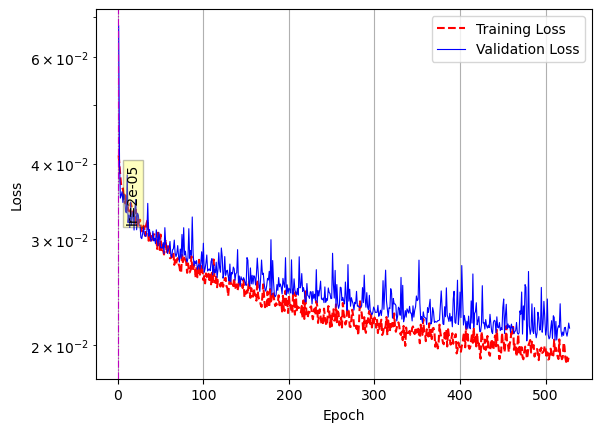

<Figure size 640x480 with 0 Axes>

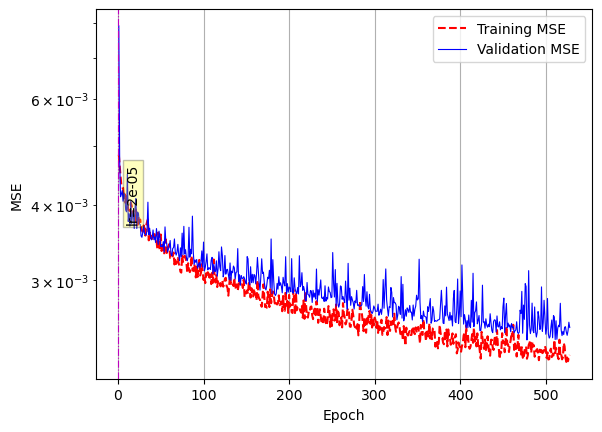

<Figure size 640x480 with 0 Axes>

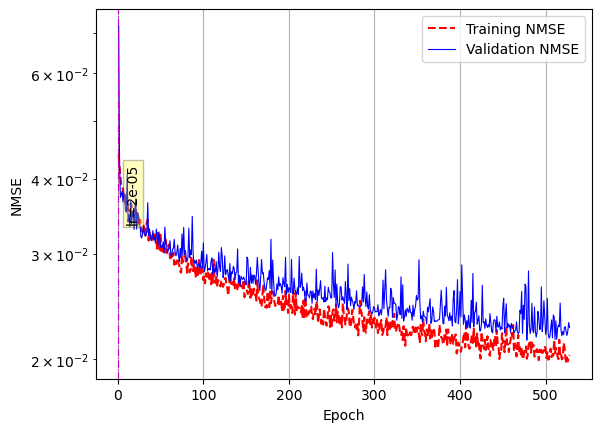

<Figure size 640x480 with 0 Axes>

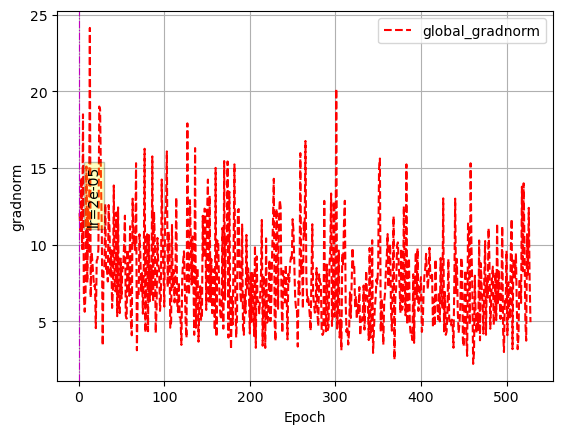

<Figure size 640x480 with 0 Axes>

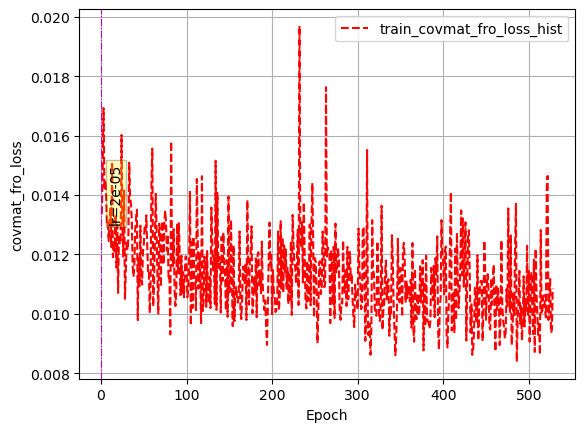



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 21.825
(462, 62, 5000) (462, 10, 5000)
init Wres made : 6.52581000328064 s.
Wres pp dealt with : 9.938727855682373 s.
sparse Wres made : 19.758586406707764 s.
spectral radius found : 50.195483446121216 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 0.0464 - mse: 0.0058 - NMSE: 0.0525 - covmat_fro_loss: 0.0143 - global_gradnorm: 21.6744 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 34.5s

Epoch 1: val_NMSE imp

Epoch 9/1000
22/22 [==============================] - ETA: 0s - loss: 0.0428 - mse: 0.0053 - NMSE: 0.0484 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.4157 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 13.3s

Epoch 9: val_NMSE did not improve from 0.04758
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 561ms/step - loss: 0.0428 - mse: 0.0053 - NMSE: 0.0484 - covmat_fro_loss: 0.0142 - global_gradnorm: 21.4335 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0433 - val_mse: 0.0054 - val_NMSE: 0.0489 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
22/22 [==============================] - ETA: 0s - loss: 0.0431 - mse: 0.0054 - NMSE: 0.0487 - covmat_fro_loss: 0.0141 - global_gradno

Epoch 19/1000
22/22 [==============================] - ETA: 0s - loss: 0.0434 - mse: 0.0054 - NMSE: 0.0490 - covmat_fro_loss: 0.0143 - global_gradnorm: 21.6171 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 4m 16.2s

Epoch 19: val_NMSE did not improve from 0.04758
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0434 - mse: 0.0054 - NMSE: 0.0490 - covmat_fro_loss: 0.0145 - global_gradnorm: 21.6261 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0479 - val_mse: 0.0060 - val_NMSE: 0.0541 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
22/22 [==============================] - ETA: 0s - loss: 0.0425 - mse: 0.0053 - NMSE: 0.0480 - covmat_fro_loss: 0.0142 - global_grad

Epoch 29/1000
22/22 [==============================] - ETA: 0s - loss: 0.0413 - mse: 0.0052 - NMSE: 0.0466 - covmat_fro_loss: 0.0142 - global_gradnorm: 21.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 6m 19.1s

Epoch 29: val_NMSE did not improve from 0.04758
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0413 - mse: 0.0052 - NMSE: 0.0466 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0428 - val_mse: 0.0053 - val_NMSE: 0.0483 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
22/22 [==============================] - ETA: 0s - loss: 0.0419 - mse: 0.0052 - NMSE: 0.0473 - covmat_fro_loss: 0.0142 - global_grad

Epoch 39/1000
22/22 [==============================] - ETA: 0s - loss: 0.0408 - mse: 0.0051 - NMSE: 0.0461 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 8m 21.9s

Epoch 39: val_NMSE did not improve from 0.04758
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0408 - mse: 0.0051 - NMSE: 0.0461 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.8250 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0443 - val_mse: 0.0055 - val_NMSE: 0.0500 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 40/1000
22/22 [==============================] - ETA: 0s - loss: 0.0421 - mse: 0.0053 - NMSE: 0.0475 - covmat_fro_loss: 0.0144 - global_grad

Epoch 49/1000
22/22 [==============================] - ETA: 0s - loss: 0.0395 - mse: 0.0049 - NMSE: 0.0445 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.5391 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 10m 24.9s

Epoch 49: val_NMSE did not improve from 0.04731
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 561ms/step - loss: 0.0395 - mse: 0.0049 - NMSE: 0.0445 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.5515 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0440 - val_mse: 0.0055 - val_NMSE: 0.0497 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 50/1000
22/22 [==============================] - ETA: 0s - loss: 0.0396 - mse: 0.0049 - NMSE: 0.0446 - covmat_fro_loss: 0.0141 - global_gra

Epoch 59/1000
22/22 [==============================] - ETA: 0s - loss: 0.0390 - mse: 0.0049 - NMSE: 0.0440 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.0117 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 27.8s

Epoch 59: val_NMSE did not improve from 0.04686
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0390 - mse: 0.0049 - NMSE: 0.0440 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.0471 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0431 - val_mse: 0.0054 - val_NMSE: 0.0486 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 60/1000
22/22 [==============================] - ETA: 0s - loss: 0.0393 - mse: 0.0049 - NMSE: 0.0443 - covmat_fro_loss: 0.0140 - global_gra

Epoch 69/1000
22/22 [==============================] - ETA: 0s - loss: 0.0400 - mse: 0.0050 - NMSE: 0.0450 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.0048 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 30.6s

Epoch 69: val_NMSE did not improve from 0.04686
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 559ms/step - loss: 0.0400 - mse: 0.0050 - NMSE: 0.0450 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.0405 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0474 - val_mse: 0.0059 - val_NMSE: 0.0535 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 70/1000
22/22 [==============================] - ETA: 0s - loss: 0.0387 - mse: 0.0048 - NMSE: 0.0437 - covmat_fro_loss: 0.0139 - global_gra

Epoch 79/1000
22/22 [==============================] - ETA: 0s - loss: 0.0399 - mse: 0.0050 - NMSE: 0.0450 - covmat_fro_loss: 0.0142 - global_gradnorm: 21.1736 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 16m 33.4s

Epoch 79: val_NMSE did not improve from 0.04686
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0399 - mse: 0.0050 - NMSE: 0.0450 - covmat_fro_loss: 0.0142 - global_gradnorm: 20.8401 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0422 - val_mse: 0.0053 - val_NMSE: 0.0476 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 80/1000
22/22 [==============================] - ETA: 0s - loss: 0.0389 - mse: 0.0048 - NMSE: 0.0439 - covmat_fro_loss: 0.0140 - global_gra

Epoch 89/1000
22/22 [==============================] - ETA: 0s - loss: 0.0403 - mse: 0.0050 - NMSE: 0.0454 - covmat_fro_loss: 0.0142 - global_gradnorm: 21.6050 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 36.2s

Epoch 89: val_NMSE did not improve from 0.04686
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0403 - mse: 0.0050 - NMSE: 0.0454 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.6146 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0418 - val_mse: 0.0052 - val_NMSE: 0.0471 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 90/1000
22/22 [==============================] - ETA: 0s - loss: 0.0380 - mse: 0.0047 - NMSE: 0.0428 - covmat_fro_loss: 0.0139 - global_gra

Epoch 99/1000
22/22 [==============================] - ETA: 0s - loss: 0.0388 - mse: 0.0048 - NMSE: 0.0437 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.4121 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 20m 39.1s

Epoch 99: val_NMSE did not improve from 0.04678
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 559ms/step - loss: 0.0388 - mse: 0.0048 - NMSE: 0.0437 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.4301 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0419 - val_mse: 0.0052 - val_NMSE: 0.0472 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 100/1000
22/22 [==============================] - ETA: 0s - loss: 0.0379 - mse: 0.0047 - NMSE: 0.0428 - covmat_fro_loss: 0.0139 - global_gr

Epoch 109/1000
22/22 [==============================] - ETA: 0s - loss: 0.0373 - mse: 0.0046 - NMSE: 0.0420 - covmat_fro_loss: 0.0138 - global_gradnorm: 21.0379 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 22m 41.9s

Epoch 109: val_NMSE did not improve from 0.04678
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0373 - mse: 0.0046 - NMSE: 0.0420 - covmat_fro_loss: 0.0138 - global_gradnorm: 21.0721 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0429 - val_mse: 0.0053 - val_NMSE: 0.0484 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 110/1000
22/22 [==============================] - ETA: 0s - loss: 0.0373 - mse: 0.0047 - NMSE: 0.0421 - covmat_fro_loss: 0.0138 - global_

22/22 [==============================] - ETA: 0s - loss: 0.0384 - mse: 0.0048 - NMSE: 0.0433 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.3280 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 24m 32.7s

Epoch 118: val_NMSE did not improve from 0.04645
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0384 - mse: 0.0048 - NMSE: 0.0433 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.3496 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0448 - val_mse: 0.0056 - val_NMSE: 0.0506 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 119/1000
22/22 [==============================] - ETA: 0s - loss: 0.0374 - mse: 0.0047 - NMSE: 0.0421 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.38

Epoch 128/1000
22/22 [==============================] - ETA: 0s - loss: 0.0395 - mse: 0.0049 - NMSE: 0.0444 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.7725 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 26m 35.7s

Epoch 128: val_NMSE did not improve from 0.04637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0395 - mse: 0.0049 - NMSE: 0.0444 - covmat_fro_loss: 0.0142 - global_gradnorm: 21.7748 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0431 - val_mse: 0.0054 - val_NMSE: 0.0487 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 129/1000
22/22 [==============================] - ETA: 0s - loss: 0.0376 - mse: 0.0047 - NMSE: 0.0424 - covmat_fro_loss: 0.0139 - global_

Epoch 138/1000
22/22 [==============================] - ETA: 0s - loss: 0.0383 - mse: 0.0048 - NMSE: 0.0431 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.4823 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 28m 38.5s

Epoch 138: val_NMSE did not improve from 0.04637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 561ms/step - loss: 0.0383 - mse: 0.0048 - NMSE: 0.0431 - covmat_fro_loss: 0.0140 - global_gradnorm: 21.4972 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0420 - val_mse: 0.0052 - val_NMSE: 0.0474 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 139/1000
22/22 [==============================] - ETA: 0s - loss: 0.0389 - mse: 0.0048 - NMSE: 0.0438 - covmat_fro_loss: 0.0141 - global_

Epoch 148/1000
22/22 [==============================] - ETA: 0s - loss: 0.0363 - mse: 0.0045 - NMSE: 0.0409 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.6626 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 30m 41.3s

Epoch 148: val_NMSE did not improve from 0.04637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 562ms/step - loss: 0.0363 - mse: 0.0045 - NMSE: 0.0409 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.6696 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0458 - val_mse: 0.0057 - val_NMSE: 0.0517 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 149/1000
22/22 [==============================] - ETA: 0s - loss: 0.0383 - mse: 0.0048 - NMSE: 0.0432 - covmat_fro_loss: 0.0141 - global_

Epoch 158/1000
22/22 [==============================] - ETA: 0s - loss: 0.0374 - mse: 0.0047 - NMSE: 0.0421 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.2426 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 44.3s

Epoch 158: val_NMSE did not improve from 0.04635
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 561ms/step - loss: 0.0374 - mse: 0.0047 - NMSE: 0.0421 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.2679 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0420 - val_mse: 0.0052 - val_NMSE: 0.0473 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 159/1000
22/22 [==============================] - ETA: 0s - loss: 0.0373 - mse: 0.0046 - NMSE: 0.0420 - covmat_fro_loss: 0.0139 - global_

Epoch 168/1000
22/22 [==============================] - ETA: 0s - loss: 0.0380 - mse: 0.0047 - NMSE: 0.0429 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.6405 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 34m 47.2s

Epoch 168: val_NMSE did not improve from 0.04635
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0380 - mse: 0.0047 - NMSE: 0.0429 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.6486 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0437 - val_mse: 0.0054 - val_NMSE: 0.0493 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 169/1000
22/22 [==============================] - ETA: 0s - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0416 - covmat_fro_loss: 0.0139 - global_

Epoch 178/1000
22/22 [==============================] - ETA: 0s - loss: 0.0375 - mse: 0.0047 - NMSE: 0.0423 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.5945 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 36m 50.1s

Epoch 178: val_NMSE did not improve from 0.04635
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 561ms/step - loss: 0.0375 - mse: 0.0047 - NMSE: 0.0423 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.6045 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0489 - val_mse: 0.0061 - val_NMSE: 0.0552 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 179/1000
22/22 [==============================] - ETA: 0s - loss: 0.0374 - mse: 0.0047 - NMSE: 0.0421 - covmat_fro_loss: 0.0139 - global_

22/22 [==============================] - ETA: 0s - loss: 0.0381 - mse: 0.0047 - NMSE: 0.0429 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.4924 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 38m 40.8s

Epoch 187: val_NMSE did not improve from 0.04610
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0381 - mse: 0.0047 - NMSE: 0.0429 - covmat_fro_loss: 0.0141 - global_gradnorm: 21.5069 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0421 - val_mse: 0.0052 - val_NMSE: 0.0475 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 188/1000
22/22 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 0.0138 - global_gradnorm: 21.34

Epoch 197/1000
22/22 [==============================] - ETA: 0s - loss: 0.0376 - mse: 0.0047 - NMSE: 0.0424 - covmat_fro_loss: 0.0139 - global_gradnorm: 21.0567 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 40m 43.8s

Epoch 197: val_NMSE did not improve from 0.04567
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0376 - mse: 0.0047 - NMSE: 0.0424 - covmat_fro_loss: 0.0138 - global_gradnorm: 21.0901 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0407 - val_mse: 0.0051 - val_NMSE: 0.0459 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 198/1000
22/22 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 0.0138 - global_

Epoch 207/1000
22/22 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0045 - NMSE: 0.0407 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.5107 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 42m 46.5s

Epoch 207: val_NMSE did not improve from 0.04567
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0361 - mse: 0.0045 - NMSE: 0.0407 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.5244 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0406 - val_mse: 0.0051 - val_NMSE: 0.0458 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 208/1000
22/22 [==============================] - ETA: 0s - loss: 0.0358 - mse: 0.0045 - NMSE: 0.0403 - covmat_fro_loss: 0.0136 - global_

Epoch 217/1000
22/22 [==============================] - ETA: 0s - loss: 0.0354 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0137 - global_gradnorm: 20.5015 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 44m 49.4s

Epoch 217: val_NMSE did not improve from 0.04525
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 559ms/step - loss: 0.0354 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0136 - global_gradnorm: 20.5590 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0421 - val_mse: 0.0052 - val_NMSE: 0.0475 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 218/1000
22/22 [==============================] - ETA: 0s - loss: 0.0380 - mse: 0.0047 - NMSE: 0.0427 - covmat_fro_loss: 0.0139 - global_

Epoch 227/1000
22/22 [==============================] - ETA: 0s - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0416 - covmat_fro_loss: 0.0139 - global_gradnorm: 20.8725 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 46m 52.1s

Epoch 227: val_NMSE did not improve from 0.04525
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 561ms/step - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0416 - covmat_fro_loss: 0.0140 - global_gradnorm: 20.9140 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0412 - val_mse: 0.0051 - val_NMSE: 0.0464 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 228/1000
22/22 [==============================] - ETA: 0s - loss: 0.0366 - mse: 0.0046 - NMSE: 0.0412 - covmat_fro_loss: 0.0138 - global_

Epoch 237/1000
22/22 [==============================] - ETA: 0s - loss: 0.0359 - mse: 0.0045 - NMSE: 0.0404 - covmat_fro_loss: 0.0137 - global_gradnorm: 20.4436 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 48m 55.0s

Epoch 237: val_NMSE did not improve from 0.04525
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0359 - mse: 0.0045 - NMSE: 0.0404 - covmat_fro_loss: 0.0137 - global_gradnorm: 20.2384 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0408 - val_mse: 0.0051 - val_NMSE: 0.0460 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 238/1000
22/22 [==============================] - ETA: 0s - loss: 0.0356 - mse: 0.0044 - NMSE: 0.0401 - covmat_fro_loss: 0.0137 - global_

Epoch 247/1000
22/22 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.4933 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 50m 57.8s

Epoch 247: val_NMSE did not improve from 0.04525
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 559ms/step - loss: 0.0361 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.4708 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0412 - val_mse: 0.0051 - val_NMSE: 0.0465 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 248/1000
22/22 [==============================] - ETA: 0s - loss: 0.0368 - mse: 0.0046 - NMSE: 0.0415 - covmat_fro_loss: 0.0138 - global_

Epoch 257/1000
22/22 [==============================] - ETA: 0s - loss: 0.0356 - mse: 0.0044 - NMSE: 0.0401 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.3791 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 53m 0.6s

Epoch 257: val_NMSE did not improve from 0.04525
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 560ms/step - loss: 0.0356 - mse: 0.0044 - NMSE: 0.0401 - covmat_fro_loss: 0.0137 - global_gradnorm: 21.3843 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0406 - val_mse: 0.0051 - val_NMSE: 0.0458 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 258/1000
22/22 [==============================] - ETA: 0s - loss: 0.0365 - mse: 0.0045 - NMSE: 0.0410 - covmat_fro_loss: 0.0139 - global_g

<Figure size 640x480 with 0 Axes>

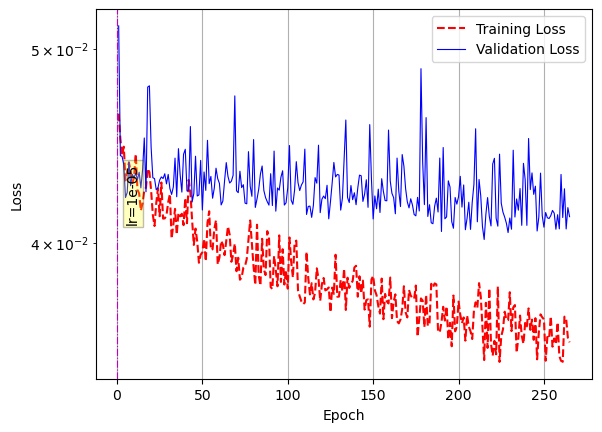

<Figure size 640x480 with 0 Axes>

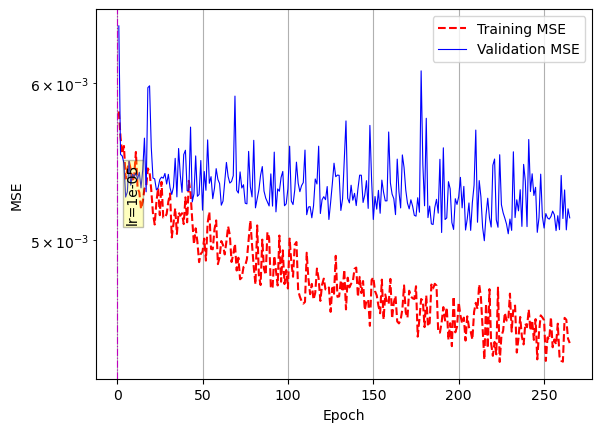

<Figure size 640x480 with 0 Axes>

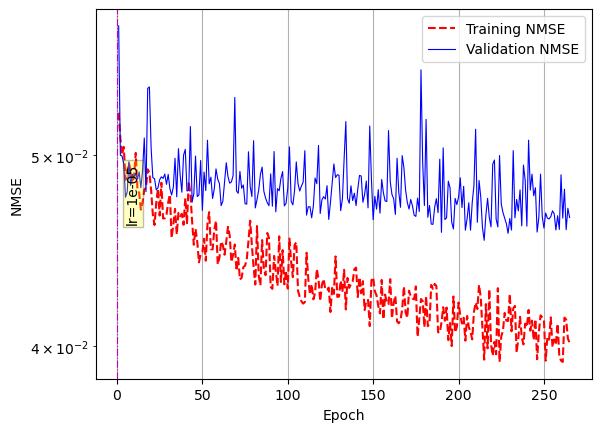

<Figure size 640x480 with 0 Axes>

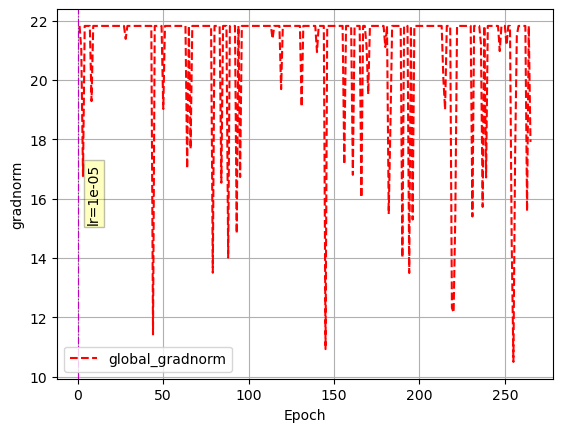

<Figure size 640x480 with 0 Axes>

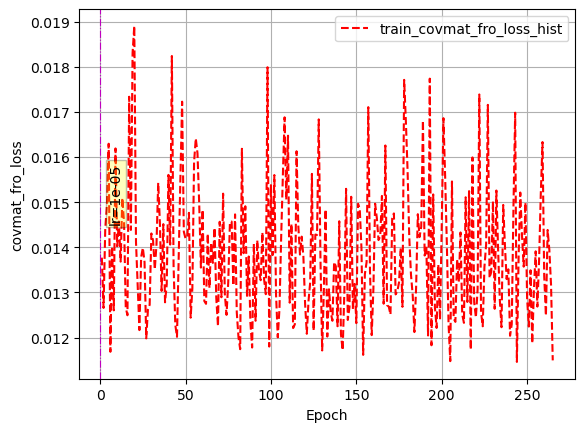



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 19.575
(362, 62, 5000) (362, 30, 5000)
init Wres made : 6.5993125438690186 s.
Wres pp dealt with : 10.012162685394287 s.
sparse Wres made : 19.726706504821777 s.
spectral radius found : 55.84409189224243 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 0.1029 - mse: 0.0167 - NMSE: 0.1511 - covmat_fro_loss: 0.0175 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 1m 23.6s

Epoch 1: val_NMSE i

Epoch 10/1000
18/18 [==============================] - ETA: 0s - loss: 0.1068 - mse: 0.0172 - NMSE: 0.1562 - covmat_fro_loss: 0.0180 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 4m 6.0s

Epoch 10: val_NMSE did not improve from 0.15443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 1s/step - loss: 0.1068 - mse: 0.0172 - NMSE: 0.1562 - covmat_fro_loss: 0.0181 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1096 - val_mse: 0.0178 - val_NMSE: 0.1610 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 11/1000
18/18 [==============================] - ETA: 0s - loss: 0.1058 - mse: 0.0171 - NMSE: 0.1548 - covmat_fro_loss: 0.0181 - global_gradnorm

Epoch 20/1000
18/18 [==============================] - ETA: 0s - loss: 0.1078 - mse: 0.0174 - NMSE: 0.1577 - covmat_fro_loss: 0.0182 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 7m 6.3s

Epoch 20: val_NMSE did not improve from 0.15443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 1s/step - loss: 0.1078 - mse: 0.0174 - NMSE: 0.1577 - covmat_fro_loss: 0.0182 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1163 - val_mse: 0.0189 - val_NMSE: 0.1713 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 21/1000
18/18 [==============================] - ETA: 0s - loss: 0.1111 - mse: 0.0179 - NMSE: 0.1625 - covmat_fro_loss: 0.0185 - global_gradnorm

Epoch 30/1000
18/18 [==============================] - ETA: 0s - loss: 0.1065 - mse: 0.0172 - NMSE: 0.1553 - covmat_fro_loss: 0.0183 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 10m 6.6s

Epoch 30: val_NMSE did not improve from 0.15443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 1s/step - loss: 0.1065 - mse: 0.0172 - NMSE: 0.1553 - covmat_fro_loss: 0.0183 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1140 - val_mse: 0.0186 - val_NMSE: 0.1680 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 31/1000
18/18 [==============================] - ETA: 0s - loss: 0.1075 - mse: 0.0173 - NMSE: 0.1569 - covmat_fro_loss: 0.0184 - global_gradnor

Epoch 40/1000
18/18 [==============================] - ETA: 0s - loss: 0.1108 - mse: 0.0179 - NMSE: 0.1618 - covmat_fro_loss: 0.0187 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 13m 7.0s

Epoch 40: val_NMSE did not improve from 0.15443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 1s/step - loss: 0.1108 - mse: 0.0179 - NMSE: 0.1618 - covmat_fro_loss: 0.0188 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1144 - val_mse: 0.0186 - val_NMSE: 0.1682 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 41/1000
18/18 [==============================] - ETA: 0s - loss: 0.1076 - mse: 0.0173 - NMSE: 0.1567 - covmat_fro_loss: 0.0186 - global_gradnor

Epoch 50/1000
18/18 [==============================] - ETA: 0s - loss: 0.1097 - mse: 0.0177 - NMSE: 0.1598 - covmat_fro_loss: 0.0187 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 16m 7.4s

Epoch 50: val_NMSE did not improve from 0.15443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 1s/step - loss: 0.1097 - mse: 0.0177 - NMSE: 0.1598 - covmat_fro_loss: 0.0186 - global_gradnorm: 19.5750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1235 - val_mse: 0.0201 - val_NMSE: 0.1818 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 51/1000
18/18 [==============================] - ETA: 0s - loss: 0.1130 - mse: 0.0183 - NMSE: 0.1652 - covmat_fro_loss: 0.0190 - global_gradnor

<Figure size 640x480 with 0 Axes>

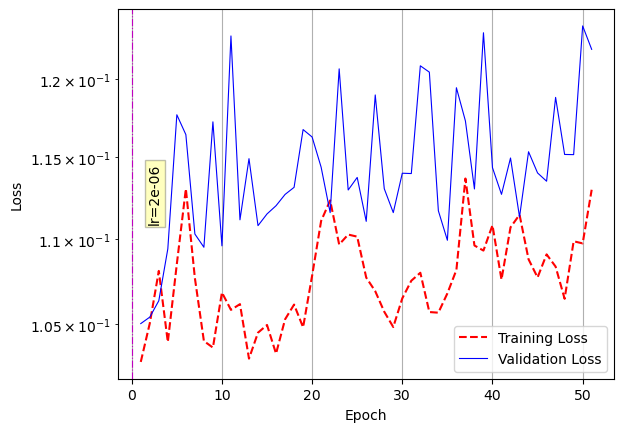

<Figure size 640x480 with 0 Axes>

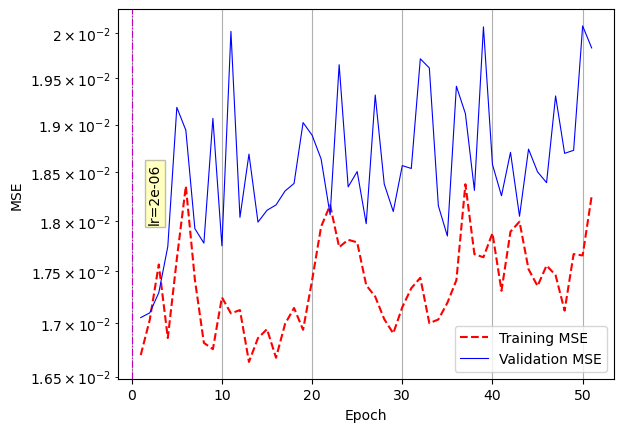

<Figure size 640x480 with 0 Axes>

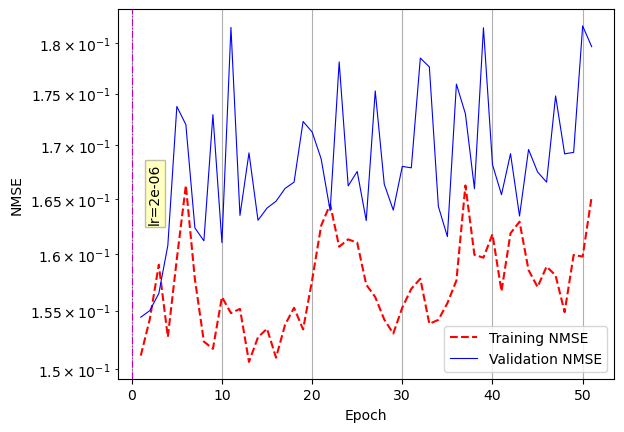

<Figure size 640x480 with 0 Axes>

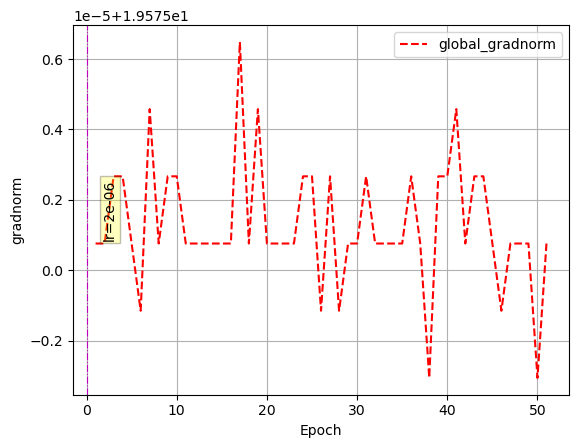

<Figure size 640x480 with 0 Axes>

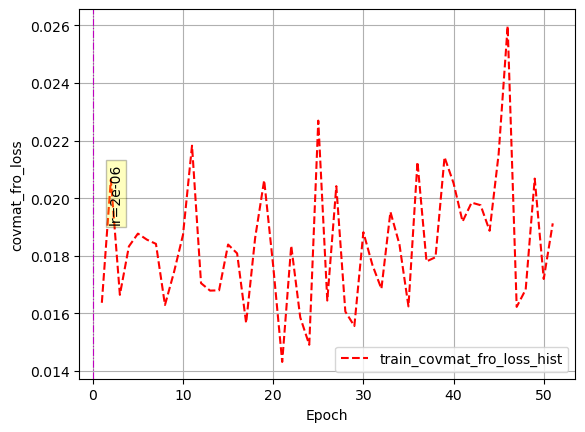



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 17.55
(297, 62, 5000) (297, 50, 5000)
init Wres made : 6.5041279792785645 s.
Wres pp dealt with : 9.90059518814087 s.
sparse Wres made : 19.6171772480011 s.
spectral radius found : 70.17066407203674 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
14/14 [==============================] - ETA: 0s - loss: 0.1406 - mse: 0.0296 - NMSE: 0.2684 - covmat_fro_loss: 0.0177 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 11.3s

Epoch 1: val_NMSE improv

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 21s 1s/step - loss: 0.2309 - mse: 0.0482 - NMSE: 0.4358 - covmat_fro_loss: 0.0237 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1830 - val_mse: 0.0374 - val_NMSE: 0.3388 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
14/14 [==============================] - ETA: 0s - loss: 0.2678 - mse: 0.0561 - NMSE: 0.5080 - covmat_fro_loss: 0.0244 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 5m 17.7s

Epoch 10: val_NMSE did not improve from 0.27666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-50_out

Epoch 19/1000
14/14 [==============================] - ETA: 0s - loss: 0.5948 - mse: 0.1192 - NMSE: 1.0787 - covmat_fro_loss: 0.0277 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 8m 23.9s

Epoch 19: val_NMSE did not improve from 0.27666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 21s 1s/step - loss: 0.5948 - mse: 0.1192 - NMSE: 1.0787 - covmat_fro_loss: 0.0277 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.5694 - val_mse: 0.1122 - val_NMSE: 1.0135 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
14/14 [==============================] - ETA: 0s - loss: 0.6182 - mse: 0.1224 - NMSE: 1.1078 - covmat_fro_loss: 0.0289 - global_gradnor

Epoch 29/1000
14/14 [==============================] - ETA: 0s - loss: 1.1111 - mse: 0.2123 - NMSE: 1.9221 - covmat_fro_loss: 0.0357 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 11m 50.9s

Epoch 29: val_NMSE did not improve from 0.27666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 21s 1s/step - loss: 1.1111 - mse: 0.2123 - NMSE: 1.9221 - covmat_fro_loss: 0.0357 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 1.0216 - val_mse: 0.1919 - val_NMSE: 1.7362 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
14/14 [==============================] - ETA: 0s - loss: 1.1170 - mse: 0.2084 - NMSE: 1.8869 - covmat_fro_loss: 0.0355 - global_gradno

Epoch 39/1000
14/14 [==============================] - ETA: 0s - loss: 1.1101 - mse: 0.2062 - NMSE: 1.8687 - covmat_fro_loss: 0.0342 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 15m 17.8s

Epoch 39: val_NMSE did not improve from 0.27666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 21s 1s/step - loss: 1.1101 - mse: 0.2062 - NMSE: 1.8687 - covmat_fro_loss: 0.0341 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 1.0322 - val_mse: 0.1929 - val_NMSE: 1.7435 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 40/1000
14/14 [==============================] - ETA: 0s - loss: 1.1119 - mse: 0.2060 - NMSE: 1.8663 - covmat_fro_loss: 0.0341 - global_gradno

Epoch 49/1000
14/14 [==============================] - ETA: 0s - loss: 1.0715 - mse: 0.2064 - NMSE: 1.8710 - covmat_fro_loss: 0.0335 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 44.7s

Epoch 49: val_NMSE did not improve from 0.27666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 21s 1s/step - loss: 1.0715 - mse: 0.2064 - NMSE: 1.8710 - covmat_fro_loss: 0.0335 - global_gradnorm: 17.5500 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 1.0238 - val_mse: 0.1983 - val_NMSE: 1.7934 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 50/1000
14/14 [==============================] - ETA: 0s - loss: 1.0637 - mse: 0.2068 - NMSE: 1.8754 - covmat_fro_loss: 0.0336 - global_gradno

<Figure size 640x480 with 0 Axes>

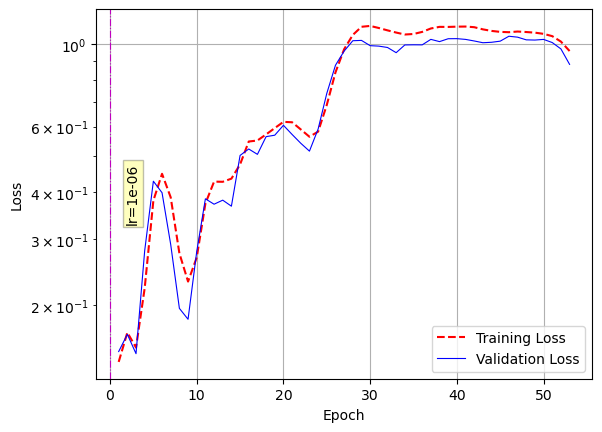

<Figure size 640x480 with 0 Axes>

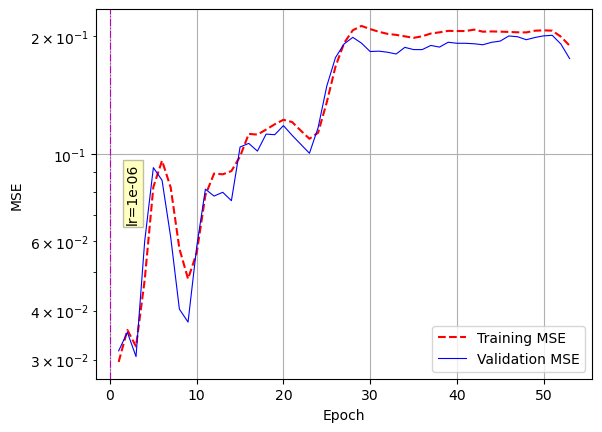

<Figure size 640x480 with 0 Axes>

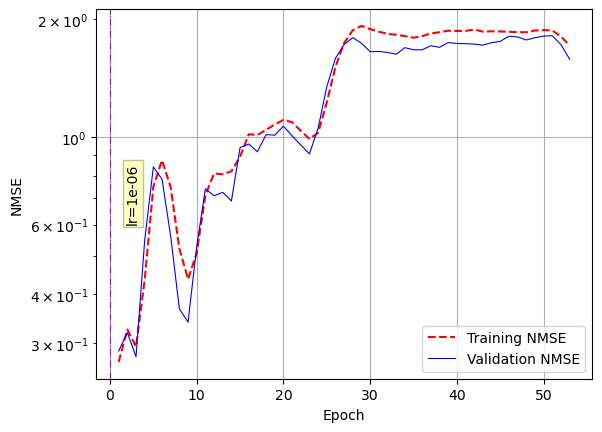

<Figure size 640x480 with 0 Axes>

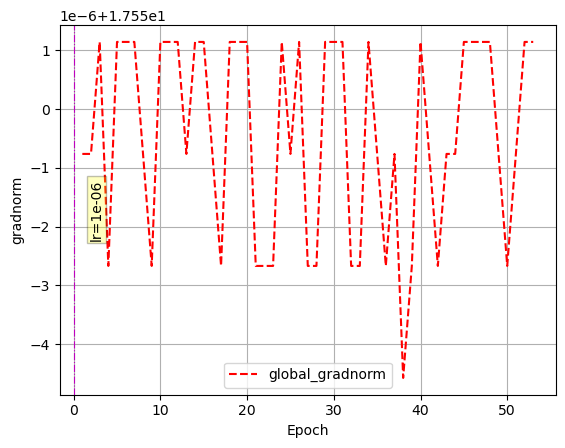

<Figure size 640x480 with 0 Axes>

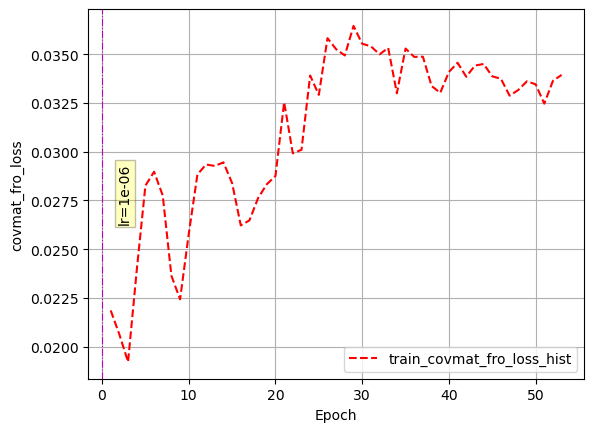

<Figure size 640x480 with 0 Axes>

In [23]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=[all_data.shape[0]],# boundary_idx_arr,
        delta_t=dt_rnn,#delta_t,
        # params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.9 * 0.25 * np.round(4*global_clipnorm)

In [24]:
batch_size*np.round(int(all_data.shape[0]*0.8)/batch_size)

26672.0

In [25]:
### Training the combined AE-RNN
# %pdb

In [26]:
normalization_constant_arr_aedata.shape

(2, 2, 50, 50)

# 